**Autor**: &nbsp; Pedro Martín Calzada &nbsp; (pedro.martinc@estudiante.uam.es)

# Curva de potencia con GPs (verosimilitud)

El objetivo de este notebook es modelar la curva de potencia de un aerogenerador. La estrategia consiste en entrenar un proceso gaussiano para cada kernel usando la totalidad de los datos disponibles de los años 2020 y 2021. Se seleccionará el kernel que proporcione la mayor verosimilitud.

## Datos Kerlmarsh Nº6 (2020-2021)

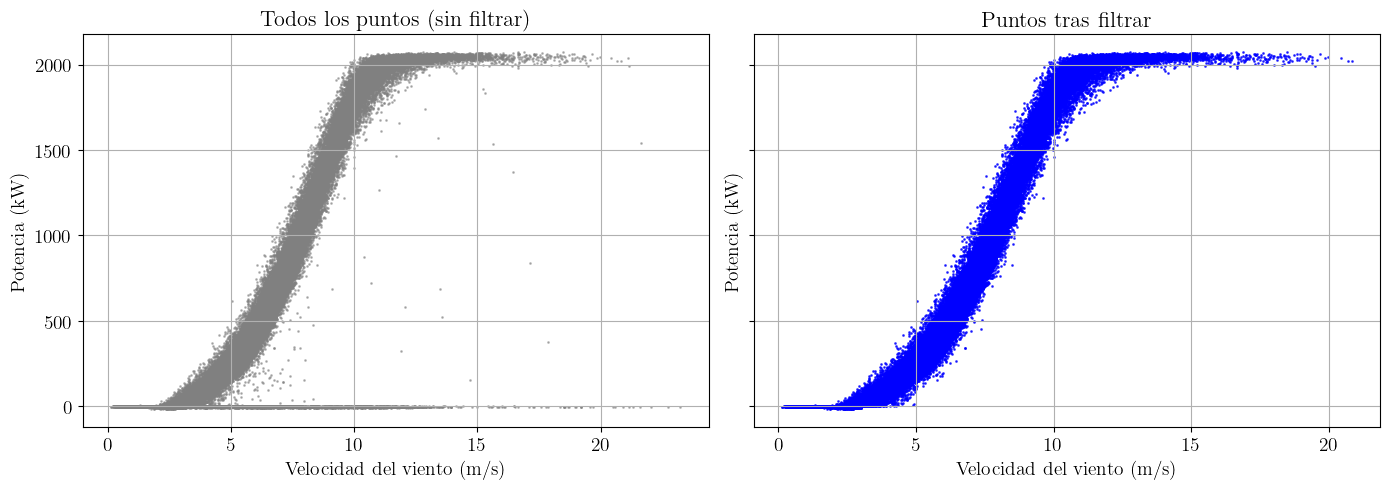

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gráficas con texto en Latex.
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Se importan los datos de 2020 y 2021 de sus respectivos CSV y se unen/concatenan para formar un df único.
df_2020 = pd.read_csv("data_2020.csv")
df_2021 = pd.read_csv("data_2021.csv")
df = pd.concat([df_2020, df_2021], ignore_index=True)

# Velocidad del viento y potencia activa.
V = df['Wind speed (m/s)']
P = df['Power (kW)']

# Máscara para limpieza o filtrado de datos.
# Muchas de las condiciones están basadas en la eliminación de puntos en rectángulos que se intersecan por lo que son redundantes (hay intersecciones).
# Se ajustan a partir de la visualización de las gráficas.
mask = (
    (P > 0) | (V < 3)          # Eliminación de potencias positivas por encima de la velocidad de arranque.
) & (V <= 21) & ~(             # Se descartan velocidades mayores de 21 m/s.
    ((V > 15) & (P < 1900)) |  # Otras condiciones de filtrado por rectángulos.
    ((V > 12) & (P < 1750)) |
    ((V > 11) & (P < 1700)) |
    ((V > 10) & (P < 1500)) |
    ((V > 7.5) & (P < 700)) |
    ((V > 7) & (P < 400)) |
    ((V > 6) & (P < 250)) |
    ((V > 5.5) & (P < 150)) |
    ((V > 5) & (P < 100))
)

# Se aplica la máscara.
V_filtered = V[mask]
P_filtered = P[mask]

# Gráficas.
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Datos sin filtrar.
axes[0].scatter(V, P, color='gray', s=1, alpha=0.5)
axes[0].set_title("Todos los puntos (sin filtrar)", fontsize=16)
axes[0].set_xlabel("Velocidad del viento (m/s)", fontsize=14)
axes[0].set_ylabel("Potencia (kW)", fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].grid(True)

# Datos filtrados.
axes[1].scatter(V_filtered, P_filtered, color='blue', s=1, alpha=0.7)
axes[1].set_title("Puntos tras filtrar", fontsize=16)
axes[1].set_xlabel("Velocidad del viento (m/s)", fontsize=14)
axes[1].set_ylabel("Potencia (kW)", fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Modelado de la curva de potencia con GPs

In [2]:
import GPy

def run_gp_model_likelihood(kernel, rated_power=2050.0):
    """
    Entrena un modelo de regresión basado en procesos gaussianos dispersos (Sparse GP) sobre 
    datos de 2020 y 2021 para modelar la curva de potencia de un aerogenerador, y visualiza
    los resultados junto con la banda de predicción del 95%.

    Parámetros:
    ----------
    kernel : GPy.kern
        Kernel de GPy configurado para el modelo GP.
    rated_power : float, opcional (por defecto = 2050.0, para este dataset)
        Potencia nominal del aerogenerador, utilizada para normalizar las salidas (potencia).

    Funcionalidad:
    -------------
    - Carga y concatena datos de 2020 y 2021.
    - Aplica una máscara para eliminar puntos inconsistentes o anómalos.
    - Normaliza la potencia de salida dividiéndola por la potencia nominal.
    - Divide el dominio del viento en bins de 0.5 m/s y selecciona hasta 10 puntos por bin 
      como puntos de inducción para el modelo GP.
    - Entrena un modelo Sparse GP usando los datos completos y puntos de inducción como soporte.
    - Visualiza los datos, la curva de potencia estimada, los puntos de inducción y la banda de 
      predicción del 95%.
    - Imprime la log-verosimilitud marginal maximizada (ELBO) y los hiperparámetros del kernel.
    """
    
    # Datos de 2020 y 2021.
    df_2020 = pd.read_csv("data_2020.csv")
    df_2021 = pd.read_csv("data_2021.csv")

    # Se concatenan y se eliminan los registros con missing values.
    df = pd.concat([df_2020, df_2021], ignore_index=True)
    df = df[['Wind speed (m/s)', 'Power (kW)']].dropna()

    V = df['Wind speed (m/s)']
    P = df['Power (kW)']

    # Máscara para limpieza o filtrado de datos.
    mask = (
        (P > 0) | (V < 3)
    ) & (V <= 21) & ~(
        ((V > 15) & (P < 1900)) |
        ((V > 12) & (P < 1750)) |
        ((V > 11) & (P < 1700)) |
        ((V > 10) & (P < 1500)) |
        ((V > 7.5) & (P < 700)) |
        ((V > 7) & (P < 400)) |
        ((V > 6) & (P < 250)) |
        ((V > 5.5) & (P < 150)) |
        ((V > 5) & (P < 100))
    )

    # Se aplica la máscara.
    V_filtered = V[mask]
    P_filtered = P[mask]

    # Formato de entradas y normalización de la potencia.
    X = V_filtered.values.reshape(-1, 1)
    Y = P_filtered.values.reshape(-1, 1)
    Y_norm = Y / rated_power

    # Separación por bins de 0'5 m/s. 
    bin_edges = np.arange(0, X.max() + 0.5, 0.5)
    inducing_points = []
    np.random.seed(37)  # Reproducibilidad.

    # Selección de puntos de inducción distribuidos por intervalos (bins) de 0.5 m/s.
    for i in range(len(bin_edges) - 1):
        # Se seleccionan los puntos cuya velocidad está dentro del bin actual.
        bin_mask = (X[:, 0] >= bin_edges[i]) & (X[:, 0] < bin_edges[i + 1])
        bin_points = X[bin_mask]
        bin_targets = Y_norm[bin_mask]

        # Si hay puntos en el bin, se seleccionan hasta 10 aleatoriamente.
        if len(bin_points) > 0:
            idx = np.random.choice(len(bin_points), size=min(10, len(bin_points)), replace=False)
            # Se combinan velocidad y potencia normalizada en una matriz.
            inducing = np.hstack((bin_points[idx], bin_targets[idx]))
            inducing_points.append(inducing)

    # Se concatenan todos los puntos de inducción de todos los bins.
    Z = np.vstack(inducing_points)

    # Se separan las entradas (velocidades) y salidas (potencias normalizadas).
    X_inducing = Z[:, 0:1]
    Y_inducing = Z[:, 1:2]

    # Z_inducing se usa como posiciones iniciales de los inducing points en el modelo GP.
    Z_inducing = X_inducing.copy()

    # Entrenamiento del modelo (cinco iteraciones).
    model = GPy.models.SparseGPRegression(X, Y_norm, kernel=kernel.copy(), Z=Z_inducing)
    model.optimize()
    # model.optimize_restarts(num_restarts=5)

    # Visualización de resultados.
    # 500 puntos equiespaciados para ver la función modelada.
    x_pred = np.linspace(0, X.max(), 500).reshape(-1, 1)
    y_pred_norm, y_var_norm = model.predict(x_pred)
    # Se recupera la escala original.
    y_pred = y_pred_norm * rated_power
    y_std = rated_power * np.sqrt(y_var_norm)

    plt.figure(figsize=(10, 5))
    plt.scatter(V, P, color='#a7dbfb', s=2, alpha=0.4, label=r'\large Datos')
    plt.plot(x_pred, y_pred, color='red', lw=2, label=r'\large Curva de potencia')
    plt.fill_between(x_pred[:, 0],
                     (y_pred - 1.96 * y_std)[:, 0],
                     (y_pred + 1.96 * y_std)[:, 0],
                     color='#dd6263', alpha=0.3, label=r'\large Banda de predicción (95\%)')
    plt.scatter(X_inducing, Y_inducing * rated_power, color='#003366', s=2, alpha=0.9, label=r'\large Puntos de inducción')
    plt.title(r"Curva de potencia de Kelmarsh Nº6", fontsize=22)
    plt.xlabel(r"Velocidad del viento (m/s)", fontsize=20)
    plt.ylabel(r"Potencia (kW)", fontsize=20)
    plt.tick_params(axis='both', labelsize=18)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Log-verosimilitud maximizada: {model.log_likelihood().item():.6f}\n")

    # Hiperparámetros.
    print("\nHiperparámetros del kernel:")
    for name, val in zip(model.kern.parameter_names(), model.kern.param_array):
        print(f"{name}: {val:.6f}")

### RBF

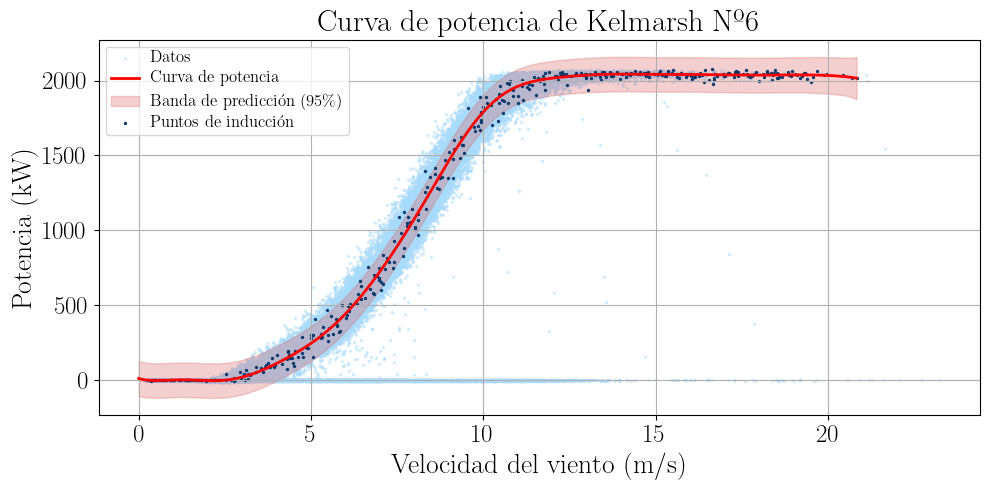

Log-verosimilitud maximizada: 211669.984066


Hiperparámetros del kernel:
variance: 0.870725
lengthscale: 2.491299


In [3]:
# Se fija una función kernel. El parámetro que recibe es la dimensión del espacio de entrada (solo velocidad del viento, luego 1 dimensión).
# No es necesario fijar los hiperparámetros porque se seleccionan aleatoriamente en cada una de las cinco iteraciones
# y después se optimizan con un algoritmo (L-BFGS-B, una versión más sofisticada del desceno por el gradiente clásico).
# Se hace lo mismo con cada uno de los 5 kernels restantes.

kernel_rbf = GPy.kern.RBF(1)
run_gp_model_likelihood(kernel_rbf)

### Racional cuadrático

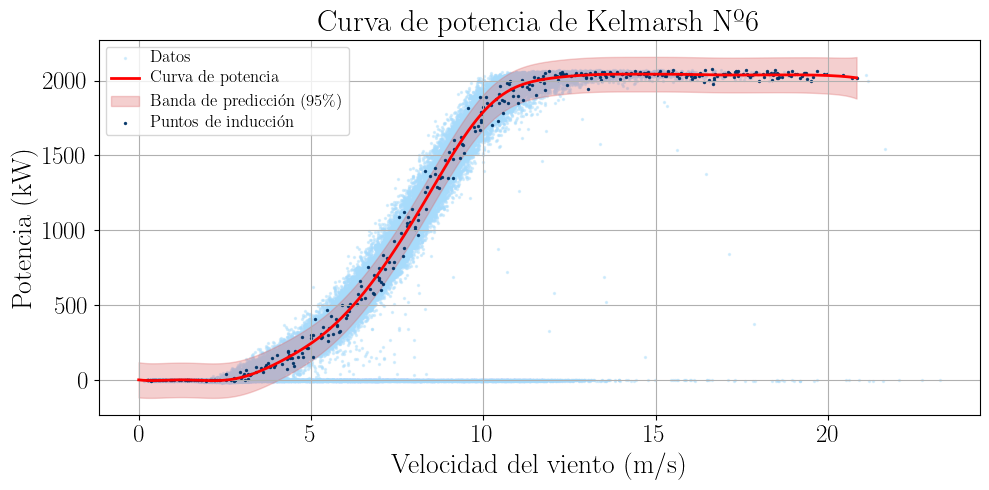

Log-verosimilitud maximizada: 211682.560267


Hiperparámetros del kernel:
variance: 0.578811
lengthscale: 4.789619
power: 1.150121


In [4]:
kernel_rq = GPy.kern.RatQuad(1)
run_gp_model_likelihood(kernel_rq)

### Matérn 3/2

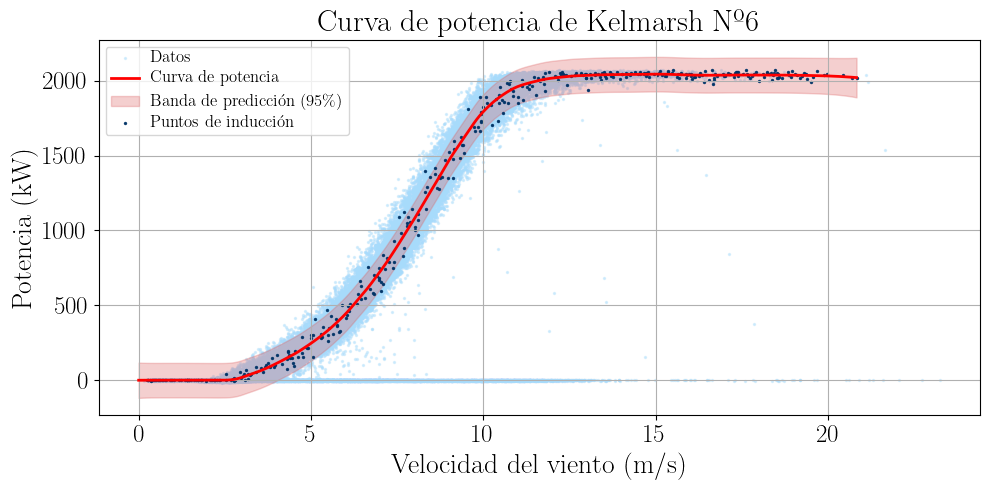

Log-verosimilitud maximizada: 211686.183380


Hiperparámetros del kernel:
variance: 0.347096
lengthscale: 22.130480


In [3]:
kernel_m32 = GPy.kern.Matern32(1)
run_gp_model_likelihood(kernel_m32)

### Matérn 5/2

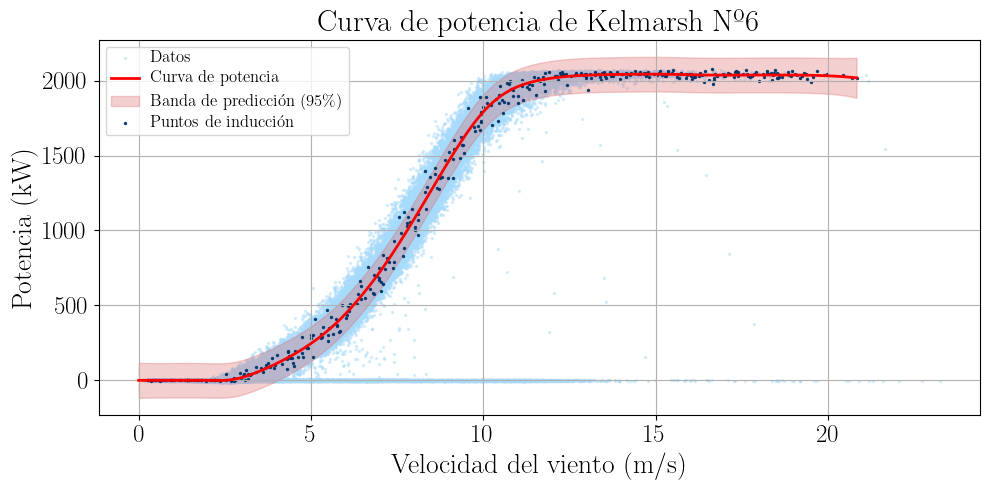

Log-verosimilitud maximizada: 211697.492104


Hiperparámetros del kernel:
variance: 0.428641
lengthscale: 10.393257


In [4]:
kernel_m52 = GPy.kern.Matern52(1)
run_gp_model_likelihood(kernel_m52)

### RBF + Matérn 3/2

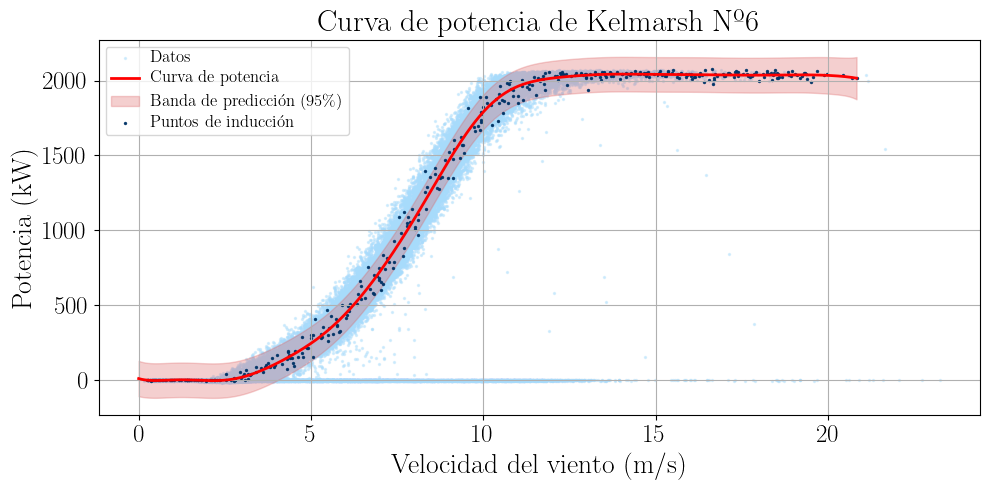

Log-verosimilitud maximizada: 211670.344624


Hiperparámetros del kernel:
Mat32.variance: 0.000030
Mat32.lengthscale: 25.896124
rbf.variance: 0.787239
rbf.lengthscale: 2.482960


In [6]:
kernel_rbf_m32 = GPy.kern.Matern32(1) + GPy.kern.RBF(1)
run_gp_model_likelihood(kernel_rbf_m32)

### Lineal + Racional cuadrático

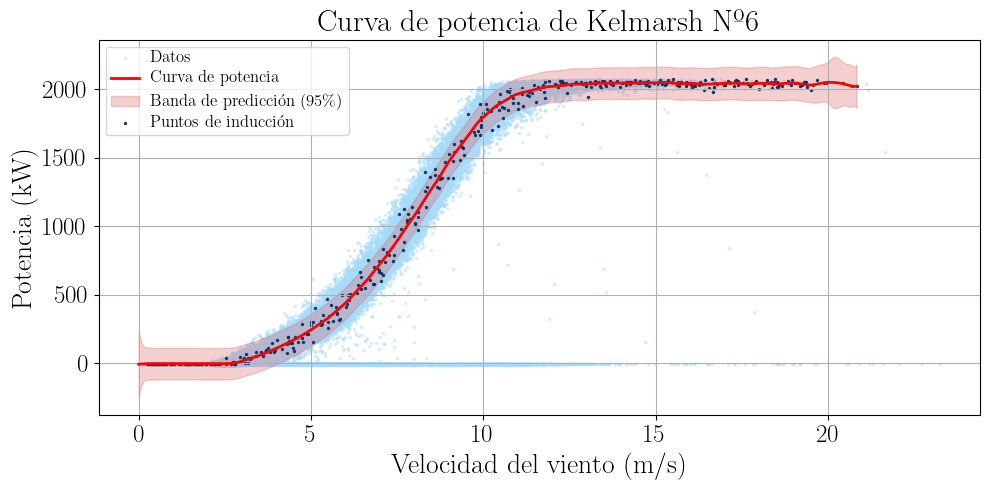

Log-verosimilitud maximizada: 211463.072111


Hiperparámetros del kernel:
linear.variances: 0.999952
RatQuad.variance: 0.997759
RatQuad.lengthscale: 1.008725
RatQuad.power: 1.996920


In [7]:
kernel_linear_rq = GPy.kern.Linear(1) + GPy.kern.RatQuad(1)
run_gp_model_likelihood(kernel_linear_rq)

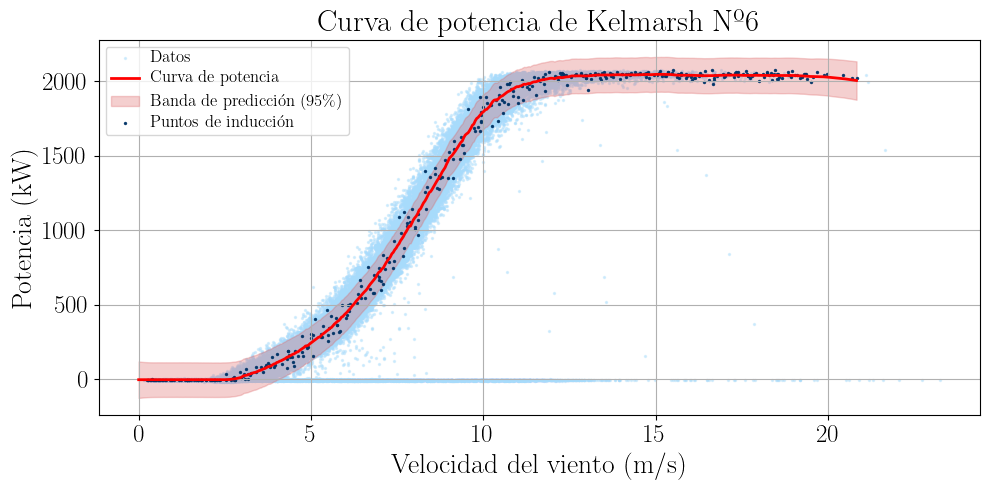

Log-verosimilitud maximizada: 211219.967646


Hiperparámetros del kernel:
variance: 0.008032
lengthscale: 48.045926


In [3]:
kernel_m12 = GPy.kern.Exponential(1)
run_gp_model_likelihood(kernel_m12)

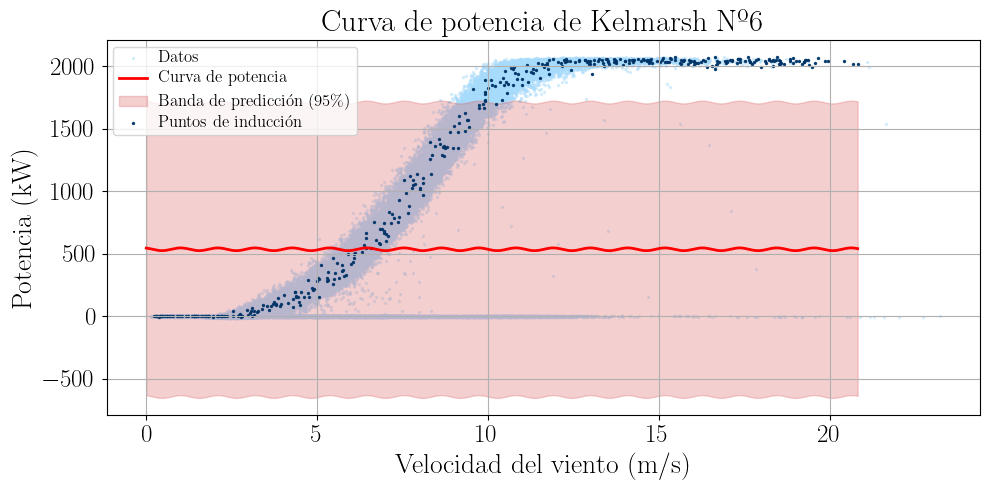

Log-verosimilitud maximizada: -19149.243030


Hiperparámetros del kernel:
variance: 0.029247
period: 1.090855
lengthscale: 15.748188


In [4]:
kernel_per = GPy.kern.StdPeriodic(1)
run_gp_model_likelihood(kernel_per)